
[<img align="right" src="./doc/jupyter_nb/Hexapod_general_Anim.gif" width="10%" height="10%">](./doc/jupyter_nb/Hexapod_general_Anim.gif)
 
## Using Stewart Platform as a tool to understand key robotic concepts

The most basic configuration of Stewart Platforms uses 6 legs, each connecting the **base** to the **platform**. They are arranged in 3 pairs, connected with universal joints and actuated linearly. The locations where the legs connect to the base and platforms are called **anchors**.

In this tutorial you will learn to solve the inverse kinematics of stewart platforms with (1) **linear actuators** (left), then (2) **rotational actuators** (right).

[<img src="./doc/jupyter_nb/plot_linear.png" width="40%" height="40%">](./doc/jupyter_nb/plot_linear.png)
[<img src="./doc/jupyter_nb/plot_rotational.png" width="40%" height="40%">](./doc/jupyter_nb/plot_rotational.png)


#### Base and Platform Anchors 
The basic parameters that decide the mechanical configuration are typically denoted by 

$r_B$. Radius of Base (Bottom)

$r_P$, Radius of Platform (Top) 

$\gamma_B$, Half of angle between two anchors on the base

$\gamma_P$, Half of angle between two anchors on the platform


From these $\gamma_B$ and $\gamma_P$, we can define  $ \psi_B \in \R ^ {6 \times 1}$ and $ \psi_P \in \R ^ {6 \times 1}$  the polar coordinates of the anchors on a unit circle radius.

Given $r_B$ and $r_P$, we can define  $B \in \R ^{6 \times 3}$ and $P \in \R ^{6 \times 3}$  which are the coordinates of the anchors in their respective local frames in cartesian space. For example, the anchor points on the base, B are illustrated below:

[<img src="./doc/jupyter_nb/base_kinematic_1.png" width="50%" height="50%">](./doc/jupyter_nb/base_kinematic_1.png)


In [7]:
import numpy as np
r_B, r_P, gamma_B, gamma_P = 6.2, 5, 0.2269, 0.82
# 0.2269rad is 13 degrees, which is standard gamma_B for stewart platforms

pi = np.pi

## Define the Geometry of the platform
# Psi_B (Polar coordinates)
psi_B = np.array([ 
    -gamma_B, 
    gamma_B,
    2*pi/3 - gamma_B, 
    2*pi/3 + gamma_B, 
    2*pi/3 + 2*pi/3 - gamma_B, 
    2*pi/3 + 2*pi/3 + gamma_B])

# psi_P (Polar coordinates)
# Direction of the points where the rod is attached to the platform.
psi_P = np.array([ 
    pi/3 + 2*pi/3 + 2*pi/3 - gamma_P,
    pi/3 + 2*pi/3 + 2*pi/3 + gamma_P,
    pi/3 + -gamma_P, 
    pi/3 + gamma_P,
    pi/3 + 2*pi/3 - gamma_P, 
    pi/3 + 2*pi/3 + gamma_P, ])

# Coordinate of the points where servo arms 
# are attached to the corresponding servo axis.
B = r_B * np.array( [ 
    [ np.cos(psi_B[0]), np.sin(psi_B[0]), 0],
    [ np.cos(psi_B[1]), np.sin(psi_B[1]), 0],
    [ np.cos(psi_B[2]), np.sin(psi_B[2]), 0],
    [ np.cos(psi_B[3]), np.sin(psi_B[3]), 0],
    [ np.cos(psi_B[4]), np.sin(psi_B[4]), 0],
    [ np.cos(psi_B[5]), np.sin(psi_B[5]), 0] ])
B = np.transpose(B)
    
# Coordinates of the points where the rods 
# are attached to the platform.
P = r_P * np.array([ 
    [ np.cos(psi_P[0]),  np.sin(psi_P[0]), 0],
    [ np.cos(psi_P[1]),  np.sin(psi_P[1]), 0],
    [ np.cos(psi_P[2]),  np.sin(psi_P[2]), 0],
    [ np.cos(psi_P[3]),  np.sin(psi_P[3]), 0],
    [ np.cos(psi_P[4]),  np.sin(psi_P[4]), 0],
    [ np.cos(psi_P[5]),  np.sin(psi_P[5]), 0] ])
P = np.transpose(P)

print('6x3 array for Base anchors \n', B)
print('6x1 array for psi_B \n', psi_B)

print('6x3 array for Platform anchors \n', P)
print('6x1 array for psi_P \n', psi_P)

AttributeError: 'float' object has no attribute 'pi'

We can plot this using matplotlib


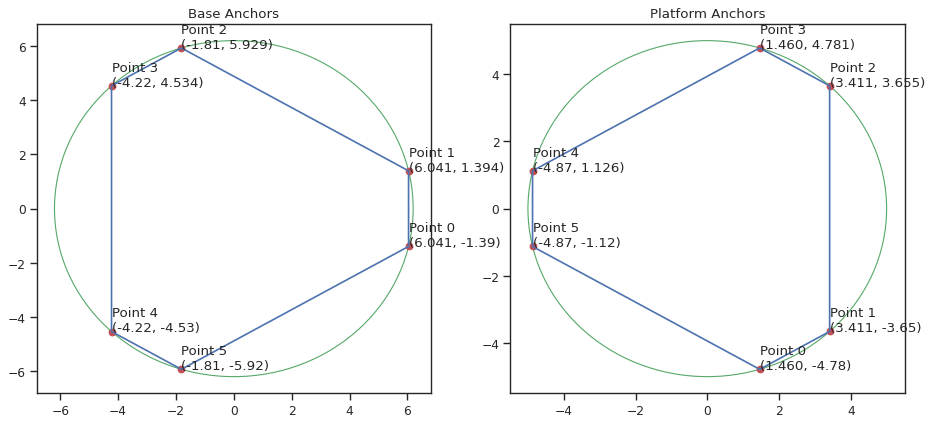

In [5]:
import matplotlib.pyplot as plt
import seaborn

def plot_2D_annotate(X, Y):
    X = list(X)
    Y = list(Y)
    ax.plot(X,Y, 'or')  # Plot Points
    # Annotate Points
    for i, (xy) in enumerate(zip(X, Y)):                                 
        ax.annotate('Point ' + str(i) + '\n(%.5s, %.5s)' % xy, xy=xy, textcoords='data')

    X.append(X[0])
    Y.append(Y[0])
    ax.plot(X,Y)    # Plot lines

seaborn.set(style='ticks')
# plt.style.use('dark_background')

fig = plt.figure(figsize=(14, 6), dpi=80)

ax = fig.add_subplot(121)
ax.set_title('Base Anchors')
plot_2D_annotate(B[0,:], B[1,:])
circle_B = plt.Circle((0, 0), r_B, color='g', fill=False)
ax.add_patch(circle_B)

ax = fig.add_subplot(122)
ax.set_title('Platform Anchors')
plot_2D_annotate(P[0,:], P[1,:])
circle_r = plt.Circle((0, 0), r_P, color='g', fill=False)
ax.add_patch(circle_r)

plt.show()

#### Defining Home Position

The next step is to define the displacement between the base and the platform at home position, $h$. This is the length of your linear actuators at rest. We'll assume it's radius of your base plate.

We also need to define the rotation matrices following the standard notation

[<img src="./doc/jupyter_nb/rotation_matrices.png">](./doc/jupyter_nb/rotation_matrices.png)


In [45]:
# # Definition of the platform home position.
home_pos= np.array([0, 0, 2*r_B])

# Allocate for variables
l = np.zeros((3,6))
lll = np.zeros((6))

# Rotation matrices used later
def rotX(theta):
    rotx = np.array([
        [1,     0    ,    0    ],
        [0,  np.cos(theta), -np.sin(theta)],
        [0,  np.sin(theta), np.cos(theta)] ])
    return rotx

def rotY(theta):    
    roty = np.array([
        [np.cos(theta), 0,  np.sin(theta) ],
        [0         , 1,     0       ],
        [-np.sin(theta), 0,  np.cos(theta) ] ])   
    return roty
    
def rotZ(theta):    
    rotz = np.array([
        [ np.cos(theta),-np.sin(theta), 0 ],
        [ np.sin(theta), np.cos(theta), 0 ],
        [   0        ,     0      , 1 ] ])   
    return rotz
    

## Solving for Inverse Kinematics using Linear Actuators

Finally we are ready to solve the inverse kinematics.

To find length of legs when given desired translation vectors $T = (t _x, t _y, t _z)^T$ and rotation vector $ \theta = (\theta _x, \theta _y, \theta _z)^T$ ,

We just have to find the new coordinates of each of the anchors on the plate after desired rotation rot and translation.

Since the role of each leg is to connect the anchor on the base to the anchor on the platform, the desired vector for each leg (direction and length) is simply the leg's position in 3D space with reference to their respective base anchor


[<img src="./doc/jupyter_nb/leg_math.png" width="80%" height="80%">](./doc/jupyter_nb/leg_math.png)


Where $T$ and $H$ are in $\R ^ {3 \times 1}$ replicated 6 times to have dimensions $\R ^ {3 \times 6}$ to facilitate matrix calculations

This can be understood as 

[<img src="./doc/jupyter_nb/leg_maths.png" width="80%" height="80%">](./doc/jupyter_nb/leg_maths.png)

The length of a leg is simply the magnitude of the leg vector 

[<img src="./doc/jupyter_nb/leg_length_mag.png" width="80%" height="80%">](./doc/jupyter_nb/leg_length_mag.png)



To get the position of the leg with reference to global frame (center of base), we just add the displacement of their respective base anchors

And that's all to solve for the inverse kinematics of stewart platforms when using linear actuators. Mad simple.


!!! P should be small caps


[<img src="./doc/jupyter_nb/legs_only_pseudocode.png" width="80%" height="80%">](./doc/jupyter_nb/legs_only_pseudocode.png)


In [35]:
# Given input trans, rotation
trans = np.transpose(np.array([0,0,0])) # X, Y, Z
rotation = np.transpose(np.array([0,0,pi/6])) # X, Y, Z

# Get rotation matrix of platform. RotZ* RotY * RotX -> matmul
# R = np.matmul( np.matmul(rotZ(rotation[2]), rotY(rotation[1])), rotX(rotation[0]) )
R = np.matmul( np.matmul(rotX(rotation[0]), rotY(rotation[1])), rotZ(rotation[2]) )

# Get leg length for each leg
# leg = np.repeat(trans[:, np.newaxis], 6, axis=1) + np.repeat(home_pos[:, np.newaxis], 6, axis=1) + np.matmul(np.transpose(R), P) - B 
l = np.repeat(trans[:, np.newaxis], 6, axis=1) + np.repeat(home_pos[:, np.newaxis], 6, axis=1) + np.matmul(R, P) - B 
lll = np.linalg.norm(l, axis=0)

# Position of leg in global frame
L = l + B

print('Leg lengths to command in order to achieve desired position of plate: \n', lll)

Leg lengths to command in order to achieve desired position of plate: 
 [12.78660249 12.78732386 12.78660249 12.78732386 12.78660249 12.78732386]


#### Plotting for Visualization

Having these leg lengths, we can plot the platform!

You should see an interactive plot like this pop out on a separate window

[<img src="./doc/jupyter_nb/plot_linear.png" width="30%" height="30%">](./doc/jupyter_nb/plot_linear.png)



In [44]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot3D_line(ax, vec_arr_origin, vec_arr_dest, color_):
    for i in range(6):
        ax.plot([vec_arr_origin[0, i] , vec_arr_dest[0, i]],
        [vec_arr_origin[1, i], vec_arr_dest[1, i]],
        [vec_arr_origin[2, i],vec_arr_dest[2, i]],
        color=color_)

#interactive plotting in separate window
# Comment out this and restart kernel if you're having issues with interactive plot (qt)
# %matplotlib qt

ax = plt.axes(projection='3d') # Data for a three-dimensional line
ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(0, 20)

# ax.add_collection3d(Poly3DCollection([list(np.transpose(s.B))]), zs='z')
ax.add_collection3d(Poly3DCollection([list(np.transpose(B))], facecolors='green', alpha=0.25))

# ax.add_collection3d(base_plot, zs='z')
ax.add_collection3d(Poly3DCollection([list(np.transpose(L))], facecolors='blue', alpha=0.25))

plot3D_line(ax, B, L, 'orange')
plt.show()


## Inverse Kinematics with Rotational Servos

What if instead of linear motors, we are to use rotational servos? To do this we replace the leg of a linear actuator with a rotating servo horn and a rod. From this we can work out a (considerably more complex) analytical solution as follows.  

[<img src="./doc/jupyter_nb/rod_kinematics_1.png" width="90%" height="90%">](./doc/jupyter_nb/rod_kinematics_1.png)

The most obvious variable is $H_k$. It is simply $h_k$ translated by $B_k$ to the global reference frame; whereas $h_k$ is simply the servo arm of length |h| lying on the x axis, rotated by $\beta_k$ offset in the z axis, then rotated by desired angle $\alpha_k$ by the y axis. Note: standard notation of rotation matrices follows a right-hand-rule convention for rotation, hence in the diagram, when we are rotating the servos 'upwards, we are rotating $-\alpha_k$. Here's a post that helped me understand [link](https://robotics.stackexchange.com/questions/10702/rotation-matrix-sign-convention-confusion)

[<img src="./doc/jupyter_nb/rod_kinematics_2.png" width="80%" height="80%">](./doc/jupyter_nb/rod_kinematics_2.png)

From here we can solve the system of equations of consisting of the magnitude of each of these variables in question 

[<img src="./doc/jupyter_nb/rod_kinematics_3.png" width="80%" height="80%">](./doc/jupyter_nb/rod_kinematics_3.png)

[<img src="./doc/jupyter_nb/rod_kinematics_4.png" width="80%" height="80%">](./doc/jupyter_nb/rod_kinematics_4.png)

Converting the vector into the form of an equation, we can simplify the variables into three variables, g, e and f. These three variables are not dependent on $\alpha_k$. The remaining terms can be simplified using trigonometric identity $e \cdot \sin \varphi+f \cdot \cos \varphi=\sqrt{e^{2}+f^{2}} \sin (\varphi+\operatorname{atan} 2(f, e))$

[<img src="./doc/jupyter_nb/rod_kinematics_5.png" width="80%" height="80%">](./doc/jupyter_nb/rod_kinematics_5.png)

[<img src="./doc/jupyter_nb/rod_kinematics_6.png" width="80%" height="80%">](./doc/jupyter_nb/rod_kinematics_6.png)

and that is it. The final equation the solved inverse kinematic solution

#### Coding

Now we can transcribe into code. First we have to declare some variables: 
|d| - rod length 
|h| - servo horn length 
From these we initialize a new reasonable home position, home_pos

We also need to define the resting orientation of the servo arms
beta - angle between xz plane and the servo arms. 
Inspired by hbartle's stewart platform implementation, we don't declare the orientations of the servo shafts, but directly define the offset angles of the servo shafts, when looking at the platform from above.  

[<img src="./doc/jupyter_nb/beta_visualized.png" width="60%" height="60%">](./doc/jupyter_nb/beta_visualized.png)


In [37]:
ldl = 12
lhl = 3
z = np.sqrt( ldl**2 + lhl**2 - (P[0] - B[0])**2 - (P[1] - B[1])**2)
home_pos= np.array([0, 0, z[0] ])

# Beta (Angle)
# Angle between the plane in which the servo arm moves and the xz-plane of the base CS.
beta = np.array([ 
    pi/2 + pi,        
    pi/2,
    2*pi/3 + pi/2 + pi , 
    2*pi/3 + pi/2,
    4*pi/3 + pi/2 + pi , 
    4*pi/3 + pi/2] )

# Allocate arrays for variables
angles = np.zeros((6))
H = np.zeros((3,6)) 


The following block calculates the angles to issue on the servo motor, depending on the leg's final positions (platform anchor positions) from the previous section. The pseudocode is as following:

[<img src="./doc/jupyter_nb/servo_horn_pseudocode.png" width="80%" height="80%">](./doc/jupyter_nb/servo_horn_pseudocode.png)

The cell should plot the results in a interactive window as follows, where

Orange lines: Legs (virtual in this case)

Red lines: Servo Horns, h

Black lines: Rods, d


[<img src="./doc/jupyter_nb/plot_rotational.png" width="30%" height="30%">](./doc/jupyter_nb/plot_rotational.png)




In [38]:
# Position of legs, wrt to their individual bases, split for clarity.
lx = l[0, :]
ly = l[1, :]
lz = l[2, :]

# Calculate auxiliary quatities g, f and e
g = lll**2 - ( ldl**2 - lhl**2 )
e = 2 * lhl * lz

# Calculate servo angles for each leg
for k in range(6):
    fk = 2 * lhl * (np.cos(beta[k]) * lx[k] + np.sin(beta[k]) * ly[k])
    
    # The wanted position could be achieved if the solution of this
    # equation is real for all i
    angles[k] = np.arcsin(g[k] / np.sqrt(e[k]**2 + fk**2)) - np.arctan2(fk,e[k])
    
    # Get postion of the point where a spherical joint connects servo arm and rod.
    H[:, k] = np.transpose([ 
        lhl * np.cos(angles[k]) * np.cos(beta[k]) + B[0,k],
        lhl * np.cos(angles[k]) * np.sin(beta[k]) + B[1,k],
        lhl * np.sin(angles[k]) ])

print(angles)


[0.60882972 0.22676629 0.60882972 0.22676629 0.60882972 0.22676629]


Plotting:

In [39]:
#interactive plotting in separate window
%matplotlib qt 

ax = plt.axes(projection='3d') # Data for a three-dimensional line

ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(0, 20)

# ax.add_collection3d(Poly3DCollection([list(np.transpose(s.B))]), zs='z')
ax.add_collection3d(Poly3DCollection([list(np.transpose(B))], facecolors='green', alpha=0.25))

# ax.add_collection3d(base_plot, zs='z')
ax.add_collection3d(Poly3DCollection([list(np.transpose(L))], facecolors='blue', alpha=0.25))

plot3D_line(ax, B, H, 'red')
plot3D_line(ax, H, L, 'black')
plot3D_line(ax, B, L, 'orange')

### Condensed python class

All the code you see in this tutorial is condensed in my python class that you can find under src/stewart_controller.py.

The only changes made between this tutorial and the python class is the inclusion of a reference rotation, which rotates the entire platform in the z-axis to align with your applications. Note: using 5pi/6 as reference rotation, you'll find that the longer edge of the top platform now aligns with the X axis, which I personally find to me more aesthetically pleasing :>



In [40]:
from src.stewart_controller import Stewart_Platform
import matplotlib.pyplot as plt
import numpy as np

# To calculate angles, initiate object
# Stewart_Platform(r_B, r_P, lhl, ldl, Psi_B, Psi_P, ref_rotation)
platform = Stewart_Platform(132/2, 100/2, 30, 130, 0.2269, 0.82, 5*np.pi/6)

# platform.calculate(np.array[tx, ty, tz],np.array[rx, ry, rz])
servo_angles = platform.calculate( np.array([0,0,0]), np.array([0, 0, 0]) )
print(servo_angles)

# To Plot
%matplotlib qt 
fig, ax = plt.subplots()
ax = platform.plot_platform()
plt.draw()

[0.25544982 0.25544982 0.25544982 0.25544982 0.25544982 0.25544982]


## Final Words

Congratulations you've learnt how to solve the inverse kinematics of a standard stewart platform! You are encouraged to change some numbers, view the code in debugging mode to access the individual variables to gain a better understanding of what is going on.

This notebook functions as a tutorial for learners to solve for the inverse kinematics. A compact python function to solve for inverse kinematics is available in this same repo.

### Next Steps
I made use of this IK solution to build a 6DOF Motion Simulator - all the resources to recreate it is provided - head over there to build your own at [Stewart Platform Motion Simulator](https://github.com/Yeok-c/Stewart_Platform_Motion_Simulator)! 





### Credits
Special thanks to my subject lecturer Dr. David Navarro-Alarcon for the helpful discussions and advises.

This particular IK solution was a combination of:
Robert Eisele's solution [link](https://www.xarg.org/paper/inverse-kinematics-of-a-stewart-platform/)

Filip Szufnarowski's paper [link](https://cdn.instructables.com/ORIG/FIQ/KEUA/I55MMY1Y/FIQKEUAI55MMY1Y.pdf)

Hbartle's MATLAB implementation [link](https://github.com/hbartle/Stewart_Platform/)